In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
A = np.array([[3114.3078867202757, 0.0, 2024.1287882076842],
              [0.0, 3115.29883025757, 1494.5787623852414],
              [0.0, 0.0, 1.0]])
R = np.array([[-0.049834160955302804, -0.9651880847933482, -0.2567654910123821],
              [0.9701119709541478, 0.01435195636904367, -0.24223291510411984],
              [0.23748541052734093, -0.2611627506390024, 0.9356252975766155]])
T = np.array([[92.90912146910826], [-98.70370842513836], [390.9599208378294]])
dist_coeffs = np.array([0.26633980232653925, -1.4695850423633692, -0.0005227352954632733,
                        0.00024124977396169545, 2.406661702653812])

square_size = 26.5
pattern_size = (9, 6)

#Initializing inner corner 3D coordinates 
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

def processImage(fn):
    # print('processing {}'.format(fn))
    img = cv2.imread(fn, 0)
    h, w = img.shape[:2]

    if img is None:
        # print("Failed to load", fn)
        return None
    # print("H {}, W {}".format(h,w))

    assert w == img.shape[1] and h == img.shape[0], ("size: %d x %d ... " % (img.shape[1], img.shape[0]))

    found, corners = cv2.findChessboardCorners(img, pattern_size)
    
    if found:
        #Refining corner position to subpixel iteratively until criteria  max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        #Image Corners 
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

    if not found:
        # print('chessboard not found')
        return None

    # print('           %s... OK' % fn)
    return (corners.reshape(-1, 2), pattern_points)

## Exercise 1a: 3D-2D correspondence

####  Using image "calibration/chessboards/0.jpg" and the calibration results, find the 2D point correspondent to the 3D point (53, 53, 0) and draw a red circle around it.
#### Solve the exercise in two different ways:
#### 1. Use the OpenCV function cv2.projectPoints(objectPoints, rvec, tvec, cameraMatrix, distCoeffs).
#### 2. Do it "manually" using the PPM matrix found in the previous exercise.

Using cv2.projectPoints:


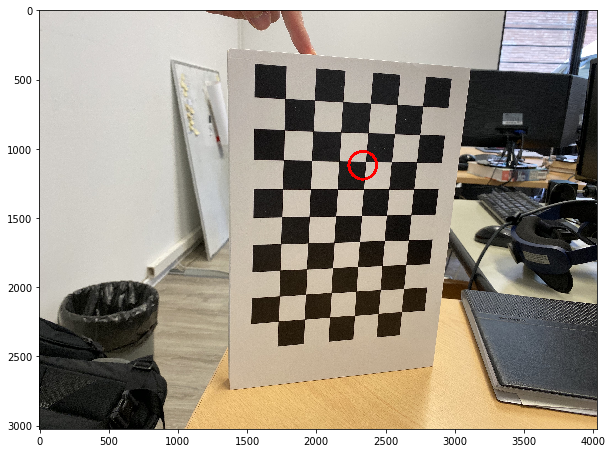

Using PPM:


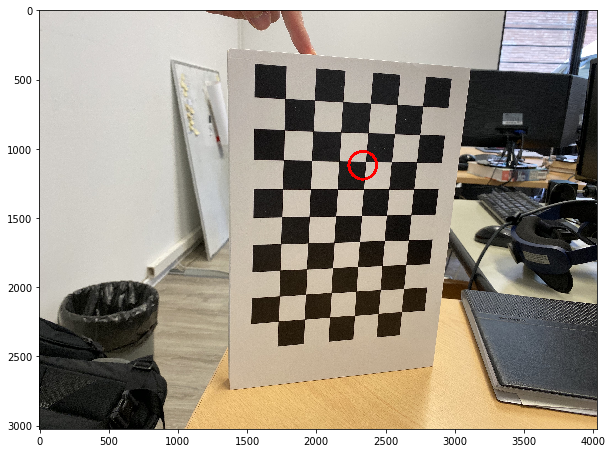

In [4]:
img = cv2.imread('calibration/chessboards/0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

_3d_point = np.array([[53.], [53.], [0.]])

print('Using cv2.projectPoints:')
_2d_point = cv2.projectPoints(_3d_point, R, T, A, dist_coeffs)[0][0, 0]
_2d_point = np.round(_2d_point).astype(np.int)

img1 = np.copy(img)

cv2.circle(img1, (_2d_point[0], _2d_point[1]), 100, (255,0,0), 20)

plt.figure(figsize=(10, 10))
plt.imshow(img1)
plt.show()

print('Using PPM:')
PPM = np.matmul(A, np.concatenate((R, T), axis=1))
_3d_point_homogeneous = np.array([[53.], [53.], [0.], [1.]])
_2d_point_homogeneous = np.matmul(PPM, _3d_point_homogeneous)
_2d_point_homogeneous = _2d_point_homogeneous / _2d_point_homogeneous[-1, 0]

img2 = np.copy(img)

cv2.circle(img2, (_2d_point[0], _2d_point[1]), 100, (255,0,0), 20)

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.show()

## Exercise 1b:
#### Using image "calibration/chessboards/0.jpg", find the 3D point correspondent to the 2D point (2348, 1295) without using the calibration results from previous exercises. In order to do that:
#### 1. Use the function processImage(image) from the theory to find 2D and 3D points of the corners of the image.
#### 2. Find the homography between the 3D and the 2D points using the OpenCV function cv2.findHomography(srcPoints, dstPoints)
#### 3. Apply the inverse of the homography to the given 2D point (2348, 1295)
#### 4. The expected result is:

Requested 2D point: 2348.0 , 1295.0


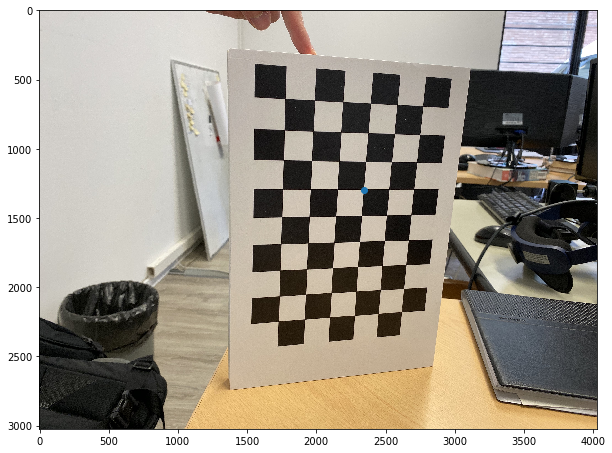

Corresponding 3D point: 79.59787214021381 , 53.0616707657814 , 0.0

Let's check the result: if we project the 3D point back to the 2D image,
we should get (almost)the original 2D point:

Reprojected 2D point: 2322 , 1331


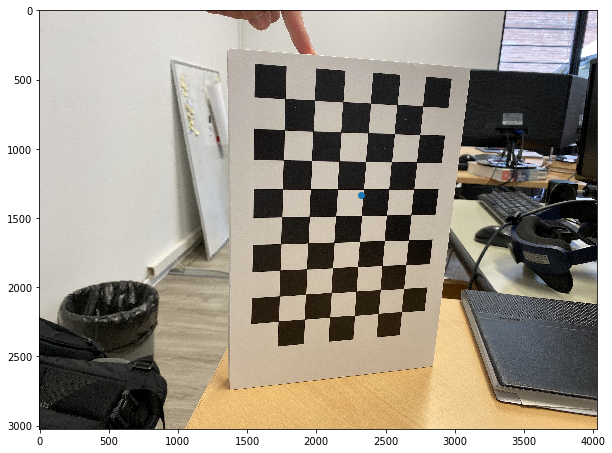

In [8]:
_2d_point_homogeneous = np.array([[2348.], [1295.], [1]])

print('Requested 2D point:', _2d_point_homogeneous[0, 0], ',', _2d_point_homogeneous[1, 0])
img3 = np.copy(img)
plt.figure(figsize=(10, 10))
plt.imshow(img3)
plt.scatter(_2d_point_homogeneous[0, 0], _2d_point_homogeneous[1, 0])
plt.show()

corners, pattern_points = processImage('calibration/chessboards/0.jpg')
homography = cv2.findHomography(pattern_points, corners, cv2.RANSAC)[0]  #from 3D to 2D

_3d_point_homogeneous = np.matmul(np.linalg.inv(homography), _2d_point_homogeneous)
_3d_point = _3d_point_homogeneous / _3d_point_homogeneous[-1]
_3d_point[-1] = 0.

print('Corresponding 3D point:', _3d_point[0, 0], ',', _3d_point[1, 0], ',', _3d_point[2, 0])

print('\nLet\'s check the result: if we project the 3D point back to the 2D image,'
      '\nwe should get (almost)the original 2D point:')
_2d_point = cv2.projectPoints(_3d_point, R, T, A, dist_coeffs)[0][0, 0]
_2d_point = np.round(_2d_point).astype(np.int)
print('\nReprojected 2D point:', _2d_point[0], ',', _2d_point[1])

img4 = np.copy(img)
plt.figure(figsize=(10, 10))
plt.imshow(img4)
plt.scatter(_2d_point[0], _2d_point[1])
plt.show()